In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer#, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
# from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, evaluate_model, calc_ccc, separate_data
### input
folder = 'http://192.168.1.30:8333/ai4sh-landmasked/model_benchmark'
from log_back_transform_rf import TreesRandomForestRegressor

df = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/data/002.2_data_whole.csv', low_memory=False)

In [18]:
covs_bd = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/bulk_density/benchmark_selected.covs_bulk_density.txt')
covs_oc = read_features(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/oc/benchmark_selected.covs_oc.txt')

dff = df.loc[(df['oc_qa']>5) & (df['bulk_density_qa']>5)]
dff = dff.dropna(subset=['oc','bulk_density']+covs_bd+covs_oc)
dfs = dff.groupby('tile_id', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))
dfs['oc_log1p'] = np.log1p(dfs['oc'])

rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=64)
cv = GroupKFold(n_splits=5) 

In [19]:
# get the mean of oc and bd first, then multiply
oc_mean_first = np.expm1(cross_val_predict(rf, dfs[covs_oc], dfs['oc_log1p'], cv=cv, groups=dfs['tile_id'], n_jobs=60))
bd_mean_first = cross_val_predict(rf, dfs[covs_bd], dfs['bulk_density'], cv=cv, groups=dfs['tile_id'], n_jobs=60)
pred_mean_first = oc_mean_first*bd_mean_first

In [ ]:
rmse = np.sqrt(mean_squared_error(dfs['ocd'],pred_mean_first)),
r2 = r2_score(np.log1p(cal[tgt]),np.log1p(y_cv)),
ccc = calc_ccc(np.log1p(cal[tgt]),np.log1p(y_cv))

<Axes: >

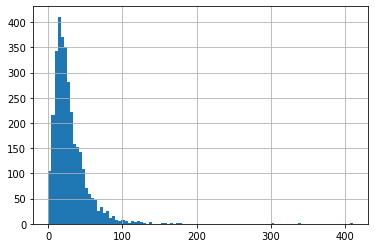

In [25]:
dfs['ocd'] = dfs['oc']*dfs['bulk_density']
dfs['ocd'].hist(bins=100)

In [38]:
dff['ocd'] = dff['oc']*dff['bulk_density']

dff['ocd_log1p'] = np.log1p(dff['ocd'])

median: 2.95, mean: 2.81


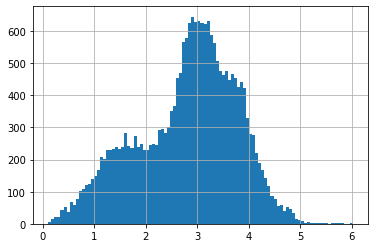

In [43]:
dff['ocd_log1p'].hist(bins=100)
md = dff['ocd_log1p'].median()
m = dff['ocd_log1p'].mean()
print(f'median: {md:.2f}, mean: {m:.2f}')

median: 18.09, mean: 23.84


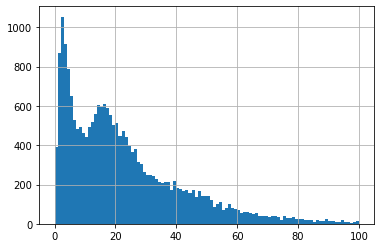

In [45]:
dff['ocd'].hist(bins=100,range=[0,100])
md = dff['ocd'].median()
m = dff['ocd'].mean()
print(f'median: {md:.2f}, mean: {m:.2f}')

2.8108441922202076

In [27]:
bd = df.loc[df['bulk_density_qa']>5]
bd = bd.dropna(subset=['bulk_density'])
bd

,id,lat,lon,time,ref,nuts0,oc,ph_h2o,ph_cacl2,bulk_density,...,lithology_EGDI_trachytoid,lithology_EGDI_tuffBrecciaAgglomerateOrPyroclasticBreccia,lithology_EGDI_ultramaficIgneousRock,lithology_EGDI_wacke,lithology_EGDI_Unpopulated,hzn_dep,texture1,texture2,texture1_qa,texture2_qa
291,PFB -- 6167,52.049350,5.446681,2000.0,nl.bis,NL,0.0675,NaN,NaN,1.500,...,False,False,False,False,False,2.0,NaN,NaN,2.0,2.0
292,PFB -- 6167,52.049350,5.446681,2000.0,nl.bis,NL,0.0675,NaN,NaN,1.500,...,False,False,False,False,False,7.0,NaN,NaN,2.0,2.0
293,PFB -- 6167,52.049350,5.446681,2000.0,nl.bis,NL,0.0675,NaN,NaN,1.500,...,False,False,False,False,False,12.5,NaN,NaN,2.0,2.0
294,PFB -- 6167,52.049350,5.446681,2000.0,nl.bis,NL,0.0675,NaN,NaN,1.500,...,False,False,False,False,False,37.5,NaN,NaN,2.0,2.0
295,PFB -- 6167,52.049350,5.446681,2000.0,nl.bis,NL,11.1450,NaN,NaN,1.300,...,False,False,False,False,False,65.0,NaN,NaN,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359031,32243654,54.803822,-7.243667,2018.0,LUCAS,UK,173.6000,5.07,4.8,0.291,...,False,False,False,False,False,10.0,NaN,NaN,10.0,10.0
359038,32463644,54.763212,-6.872958,2018.0,LUCAS,UK,36.5000,4.69,4.6,0.744,...,False,False,False,False,False,10.0,NaN,NaN,10.0,10.0
359039,32483682,55.097961,-6.983552,2018.0,LUCAS,UK,13.2000,6.32,5.7,1.382,...,False,False,False,False,False,10.0,NaN,NaN,10.0,10.0
359040,32543634,54.692770,-6.715202,2018.0,LUCAS,UK,47.9000,5.65,5.3,0.939,...,False,False,False,False,False,10.0,NaN,NaN,10.0,10.0


In [7]:
for prop in prop_list:
    old = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
    new = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/benchmark_selected.covs_{prop}.txt'
    # covariates
    oldl = read_features(old)
    newl = read_features(new)
    
    oldm = pd.read_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results/{prop}/metrics.rank_feature.elimination_{prop}.csv')
    newm = pd.read_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results_new/{prop}/metrics.rank_feature.elimination_{prop}.csv')
    
    a = oldm.loc[oldm['Num_Features']==len(oldl)]
    b = newm.loc[newm['Num_Features']==len(newl)]
    
    cm = pd.concat([)

array(['nl.bis', 'MarSOC', 'Wales.GMEP'], dtype=object)

http://192.168.1.30:8333/ai4sh/dtm/dtm.bareearth_ensemble_p10_120m_s_20000101_20221231_eu_epsg.3035_v20240424.tif
http://192.168.1.30:8333/ai4sh/dtm/dtm.bareearth_ensemble_p10_240m_s_20000101_20221231_eu_epsg.3035_v20240424.tif
http://192.168.1.30:8333/ai4sh/dtm/dtm.bareearth_ensemble_p10_30m_s_20000101_20221231_eu_epsg.3035_v20240424.tif
http://192.168.1.30:8333/ai4sh/dtm/dtm.bareearth_ensemble_p10_480m_s_20000101_20221231_eu_epsg.3035_v20240424.tif
http://192.168.1.30:8333/ai4sh/dtm/dtm.bareearth_ensemble_p10_60m_s_20000101_20221231_eu_epsg.3035_v20240424.tif
http://192.168.1.30:8333/ai4sh/dtm/dtm.bareearth_ensemble_p10_960m_s_20000101_20221231_eu_epsg.3035_v20240424.tif
http://192.168.1.30:8333/ai4sh/dtm/easterness.bareearth_ensemble_m_30m_s_20000101_20221231_eu_epsg.3035_v20240424.tif
http://192.168.1.30:8333/ai4sh/dtm/flow.accum.bareearth_ensemble_m_120m_s_20000101_20221231_eu_epsg.3035_v20240501.tif
http://192.168.1.30:8333/ai4sh/dtm/flow.accum.bareearth_ensemble_m_60m_s_20000101

In [ ]:
dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230210.tif